In [1]:
import numpy as np
from PIL import Image
from random import random

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
import networkx as nx

from scipy import sparse
import scipy.sparse.linalg

In [2]:
w = 1600

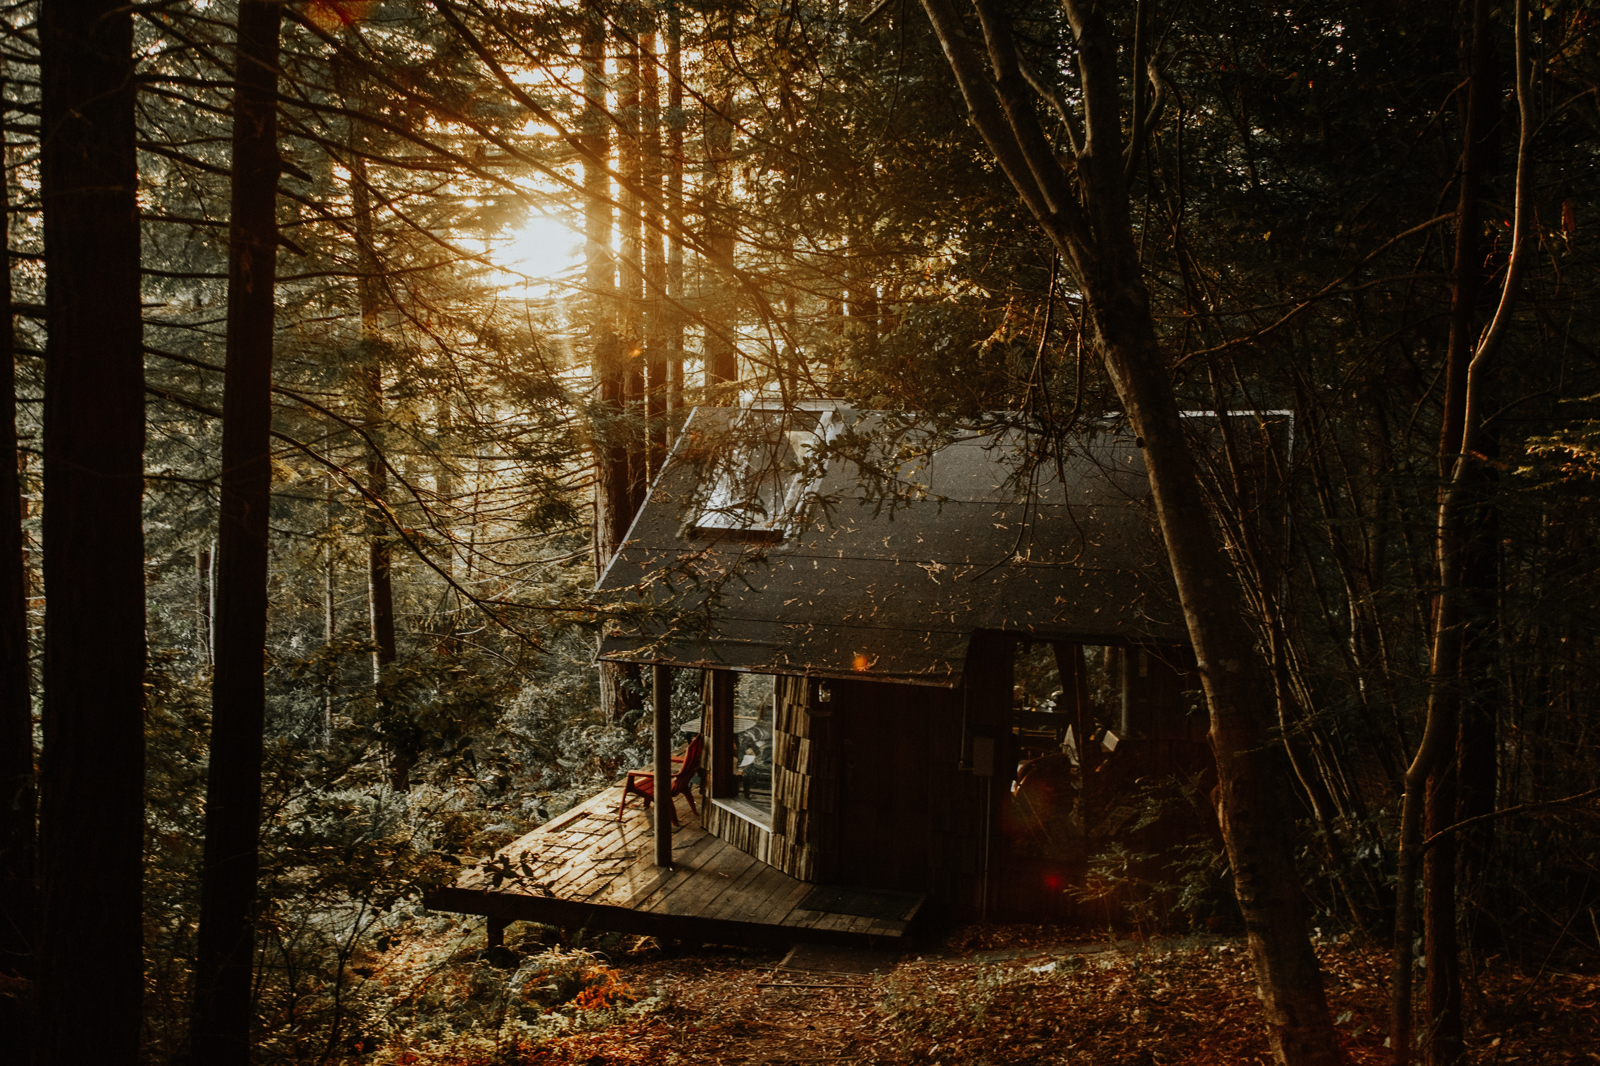

In [3]:
bg = Image.open('./unsplash-Hannah Montez.jpg')#.convert('L')
aspect = bg.height / bg.width
bg = bg.resize([w,int(w*aspect)])
bg

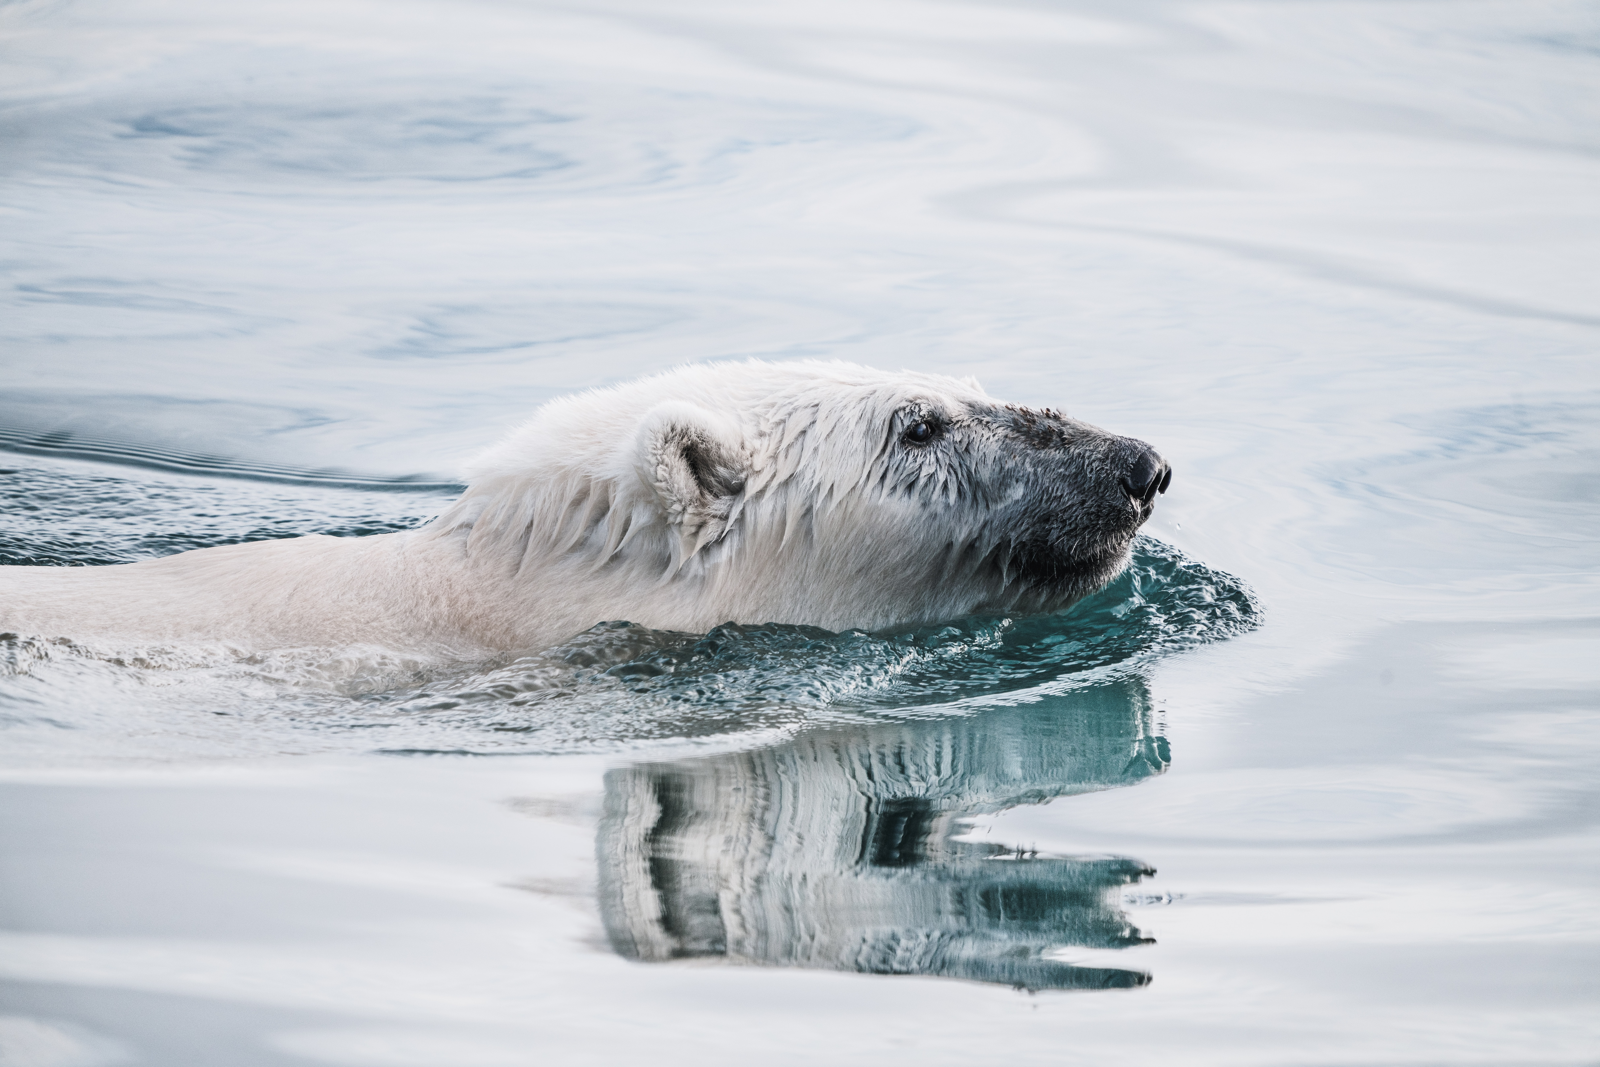

In [4]:
fg = Image.open('./annie-spratt-nt_nl97DKM0-unsplash.jpg')#.convert('L')
aspect = fg.height / fg.width
fg = fg.resize([w,int(w*aspect)])
fg

In [5]:
bg = np.array(bg).astype(np.float64)
fg = np.array(fg).astype(np.float64)

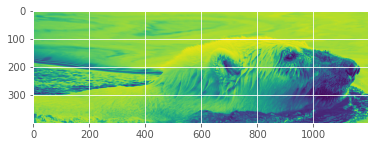

In [6]:
l,r = int(1/300*w), int(225/300*w)
t,b = int(50/300*w),int(125/300*w)
plt.imshow(fg[t:b,l:r][:,:,0]);

In [7]:
def box_interior(img, bbox):
    l,r,t,b = bbox
    h,w = img.shape[:2]
    selection = np.zeros([h,w], dtype=np.bool8)
    selection[t:b, l:r] = True
    return selection

def box_boundary(img, bbox):
    l,r,t,b = bbox
    h,w = img.shape[:2]
    selection = np.zeros([h,w], dtype=np.bool8)
    selection[t-1, l-1:r+1] = True
    selection[b, l-1:r+1] = True
    selection[t-1:b+1, l-1] = True
    selection[t-1:b+1, r] = True
    return selection

def grid_neighbor_graph(img):
    i,j = np.meshgrid(
        np.arange(img.shape[0]), 
        np.arange(img.shape[1]), 
        indexing='ij')
    self = np.stack([i,j], axis=-1)
    selfright = np.stack([self[:,:-1], self[:,1:]], axis=-2)
    selfdown = np.stack([self[:-1, :], self[1:, :]], axis=-2)
    return np.concatenate([selfright.reshape(-1,4),selfdown.reshape(-1,4)], axis=0)

In [8]:


all_edges = grid_neighbor_graph(fg)
inter = box_interior(fg, [l,r,t,b])
bound = box_boundary(fg, [l,r,t,b])

inter = np.stack(inter.nonzero(), axis=-1)
bound = np.stack(bound.nonzero(), axis=-1)

all_edges = [(tuple(e[:2]), tuple(e[2:])) for e in all_edges]
inter = [tuple(i) for i in inter]
bound = [tuple(b) for b in bound]

In [9]:
G = nx.Graph()
G.add_edges_from(all_edges)
for i in inter:
    G.nodes[i]['interior'] = True
for b in bound:
    G.nodes[b]['boundary'] = True

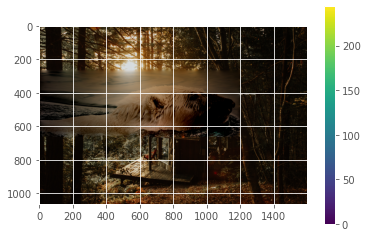

CPU times: user 2min 19s, sys: 1min 39s, total: 3min 59s
Wall time: 45.2 s


In [11]:
%%time

def v(p,q,c):
    return fg[q[0],q[1],c] - fg[p[0],p[1], c]


index = {q:i for i,q in enumerate(inter)}

f = [None, None, None]
for channel in range(3):
    b = np.zeros(len(inter))
    coef = []
    for i,q in enumerate(inter):
        coef.append([G.degree(q), i,i])
        for p in G.neighbors(q):
            if G.nodes[p].get('interior', None):
                coef.append([-1, index[q], index[p]])
            elif G.nodes[p]['boundary']:
                b[i] += bg[p][channel]
            b[i] += v(p,q,channel)
    data, row_i, col_i = zip(*coef)
    A = sparse.csr_matrix((data, (row_i, col_i)))
    f[channel] = sparse.linalg.spsolve(A, b)

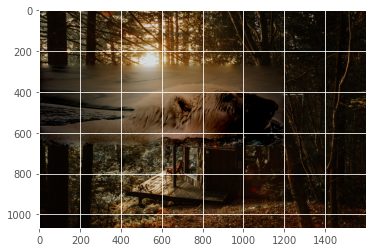

In [12]:
i = np.array(inter)
im = bg.copy()
for c in range(3):
    im[i[:,0], i[:,1], c] = f[c]
plt.imshow(im.clip(0,255).astype(np.uint8))
plt.show()